# Task-1 (Sales&Demand_Forcasting)

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error

In [14]:
df = pd.read_csv('Super.csv', encoding='ISO-8859-1')
df['Order Date'] = pd.to_datetime(df['Order Date'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9994 entries, 0 to 9993
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Row ID         9994 non-null   int64         
 1   Order ID       9994 non-null   object        
 2   Order Date     9994 non-null   datetime64[ns]
 3   Ship Date      9994 non-null   object        
 4   Ship Mode      9994 non-null   object        
 5   Customer ID    9994 non-null   object        
 6   Customer Name  9994 non-null   object        
 7   Segment        9994 non-null   object        
 8   Country        9994 non-null   object        
 9   City           9994 non-null   object        
 10  State          9994 non-null   object        
 11  Postal Code    9994 non-null   int64         
 12  Region         9994 non-null   object        
 13  Product ID     9994 non-null   object        
 14  Category       9994 non-null   object        
 15  Sub-Category   9994 n

In [15]:
df.head()

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,...,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
0,1,CA-2016-152156,2016-11-08,11/11/2016,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600,2,0.00,41.9136
1,2,CA-2016-152156,2016-11-08,11/11/2016,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400,3,0.00,219.5820
2,3,CA-2016-138688,2016-06-12,6/16/2016,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,...,90036,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.6200,2,0.00,6.8714
3,4,US-2015-108966,2015-10-11,10/18/2015,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775,5,0.45,-383.0310
4,5,US-2015-108966,2015-10-11,10/18/2015,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311,South,OFF-ST-10000760,Office Supplies,Storage,Eldon Fold 'N Roll Cart System,22.3680,2,0.20,2.5164


In [16]:
# Aggregate total daily sales
daily_sales = df.groupby('Order Date')['Sales'].sum().reset_index()
daily_sales = daily_sales.set_index('Order Date')

all_dates = pd.date_range(start=daily_sales.index.min(), end=daily_sales.index.max(), freq='D')
daily_sales = daily_sales.reindex(all_dates, fill_value=0)

# 2. FEATURE ENGINEERING
def create_features(df):
    df = df.copy()
    df['dayofweek'] = df.index.dayofweek
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear

    
    # Lag Features (Historical performance)
    df['lag_7'] = df['Sales'].shift(7)   # Sales 1 week ago
    df['lag_30'] = df['Sales'].shift(30) # Sales 1 month ago
    
    # Rolling Averages (Smoothing trends)
    df['roll_mean_7'] = df['Sales'].shift(1).rolling(window=7).mean()
    df['roll_mean_30'] = df['Sales'].shift(1).rolling(window=30).mean()
    
    return df.dropna()

data = create_features(daily_sales)



In [17]:
# 3. CHRONOLOGICAL SPLIT
# Using the last 90 days of the dataset for testing
split_date = data.index.max() - pd.Timedelta(days=90)
train = data.loc[data.index < split_date]
test = data.loc[data.index >= split_date]

X_train, y_train = train.drop(columns=['Sales']), train['Sales']
X_test, y_test = test.drop(columns=['Sales']), test['Sales']

# 4. RANDOM FOREST TRAINING
model = RandomForestRegressor(n_estimators=1000, max_depth=10, random_state=42)
model.fit(X_train, y_train)

# 5. FORECASTING & EVALUATION
predictions = model.predict(X_test)
mae = mean_absolute_error(y_test, predictions)

print(f"Mean Absolute Error: ${mae:.2f}")


Mean Absolute Error: $2066.13


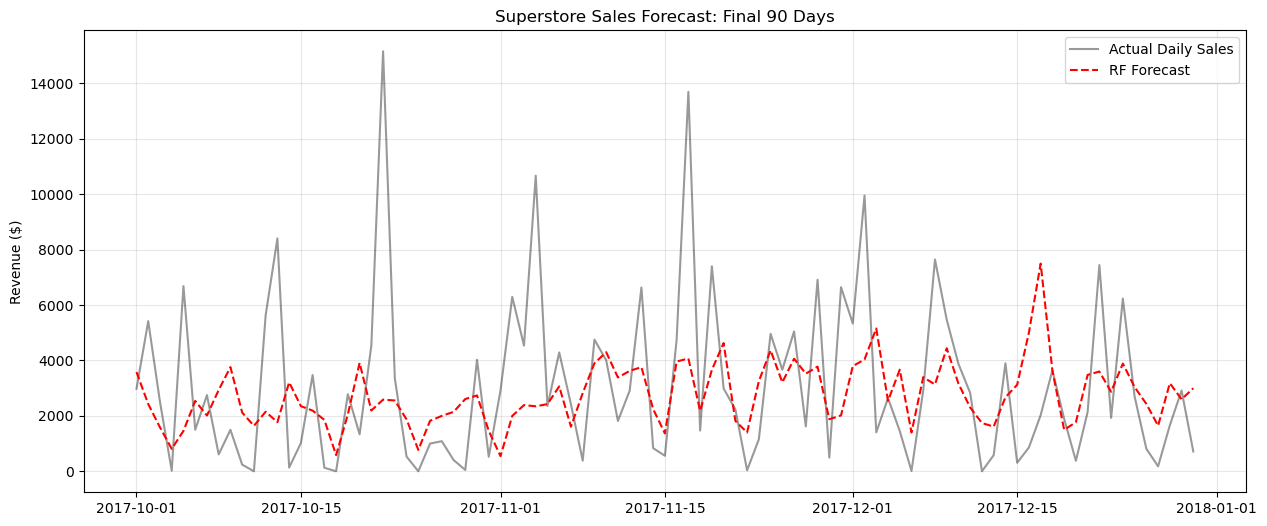

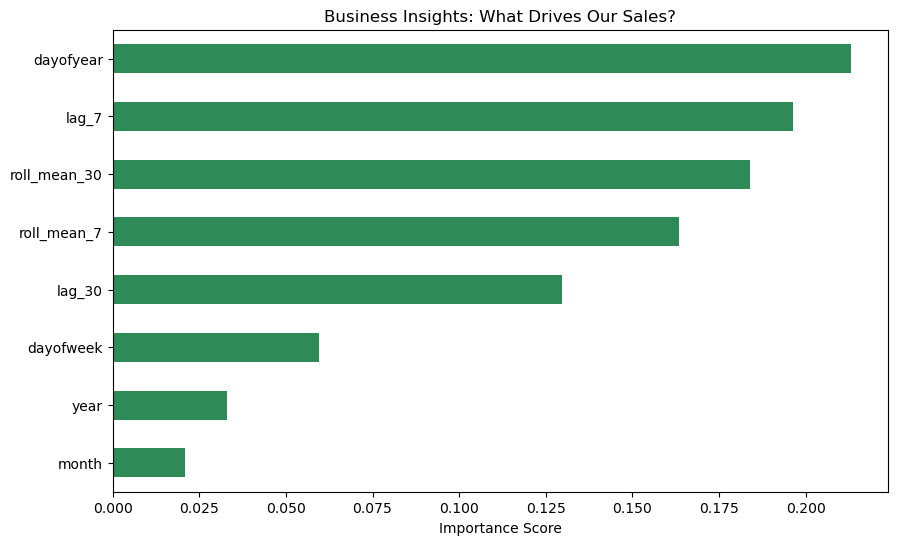

In [18]:
# 6. VISUALIZATION: FORECAST VS ACTUAL
plt.figure(figsize=(15, 6))
plt.plot(test.index, y_test, label='Actual Daily Sales', color='black', alpha=0.4)
plt.plot(test.index, predictions, label='RF Forecast', color='red', linestyle='--')
plt.title('Superstore Sales Forecast: Final 90 Days')
plt.ylabel('Revenue ($)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# 7. KEY BUSINESS DRIVERS
importances = pd.Series(model.feature_importances_, index=X_train.columns).sort_values()
importances.plot(kind='barh', color='seagreen', figsize=(10, 6))
plt.title('Business Insights: What Drives The Sales?')
plt.xlabel('Importance Score')
plt.show()